## Intrusion-Detection (Catch Me If You Can "Alice")

The notebook plays on sequential pattern mining and behavioral psychology by identifying a user on the Internet tracking their sequence of attended webpages. The algorithm will predict whether it belongs to "Alice" or somebody else.

The following code for loading libraries are preset for any Kaggle Notebooks. This notebook serves as a way of learning building new features for time series analysis.

In [42]:
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.model_selection import train_test_split # to split
from sklearn.model_selection import TimeSeriesSplit # to split
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import roc_auc_score # ROC score
from sklearn.model_selection import cross_val_score # cross validation score
from sklearn.feature_extraction.text import CountVectorizer # CountVectorizer
from sklearn.preprocessing import StandardScaler # standartization
from sklearn.preprocessing import MinMaxScaler # standartization
from sklearn.model_selection import GridSearchCV # to find best parameters
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.ensemble import BaggingClassifier # bagging
from sklearn.ensemble import VotingClassifier # ensemble models (voting and mean)
from sklearn.metrics import confusion_matrix # Confusion Matrix
from sklearn.svm import SVC # SVM
from sklearn.svm import LinearSVC # SVM
from sklearn.pipeline import make_pipeline # pipeline
from catboost import CatBoostClassifier, Pool # Yandex Gradient Boosting
import xgboost as xgb # Gradient Boosting
from mlxtend.classifier import StackingClassifier # stacking
from mlxtend.classifier import StackingCVClassifier # stacking
import lightgbm as lgb # Microsoft Gradien Boosting
import matplotlib.pyplot as plt # to plot
plt.style.use('ggplot')
import seaborn as sns # to plot
import numpy as np # to count
import pandas as pd # DataFrames
from scipy import stats # stats
import pickle # reading pckle files
from IPython.display import display # Display tables
import time # time checking
import re # regex
import eli5 # feature importance
from collections import Counter # to count
pd.set_option('display.max_columns', None) # to display max columns in DataFrames
pd.options.mode.chained_assignment = None  # turn off mistakes

In [4]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [6]:
def load_train_or_test():
    i = input('train or test ')
    if i == 'test' or i =='train':
        name = f"{i}_sessions.csv"
        df = pd.read_csv(f"../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/" + name)
        return df
    else:
        pass

In [7]:
df_train = pd.read_csv("../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv")

In [24]:
df_test = pd.read_csv("../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv")

In [9]:
df_train.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Let's take a look at where our target values equal 1 and see if we can extract any information from that. We can also think about creating new features here, being: the number of sites visited, length of the session, weekday, start/end hour, etc...

In [10]:
df_target = df_train.loc[df_train["target"] == 1]

In [11]:
df_target

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
152,153,5397,2013-11-22 13:23:49,5395.0,2013-11-22 13:23:49,22.0,2013-11-22 13:23:50,5396.0,2013-11-22 13:23:50,5402.0,2013-11-22 13:23:50,5392.0,2013-11-22 13:23:50,22.0,2013-11-22 13:23:51,35.0,2013-11-22 13:23:54,33.0,2013-11-22 13:23:54,338.0,2013-11-22 13:23:54,1
286,287,10941,2014-03-24 17:34:14,9783.0,2014-03-24 17:34:14,9786.0,2014-03-24 17:34:14,27339.0,2014-03-24 17:34:14,27338.0,2014-03-24 17:34:15,29.0,2014-03-24 17:34:15,27339.0,2014-03-24 17:34:15,9783.0,2014-03-24 17:34:15,9785.0,2014-03-24 17:34:15,10941.0,2014-03-24 17:34:15,1
429,430,37,2014-02-13 12:46:49,270.0,2014-02-13 12:48:14,32.0,2014-02-13 12:48:17,33.0,2014-02-13 12:48:18,35.0,2014-02-13 12:48:18,704.0,2014-02-13 12:48:23,29.0,2014-02-13 12:48:25,33.0,2014-02-13 12:48:48,12623.0,2014-02-13 12:48:48,704.0,2014-02-13 12:48:48,1
643,644,39,2014-02-17 16:42:03,23.0,2014-02-17 16:42:06,677.0,2014-02-17 16:42:08,22.0,2014-02-17 16:42:12,39.0,2014-02-17 16:42:12,23.0,2014-02-17 16:42:12,21.0,2014-02-17 16:42:12,678.0,2014-02-17 16:42:13,22.0,2014-02-17 16:42:15,678.0,2014-02-17 16:42:17,1
681,682,77,2013-09-12 16:21:55,879.0,2013-09-12 16:21:56,80.0,2013-09-12 16:21:58,879.0,2013-09-12 16:21:58,80.0,2013-09-12 16:22:04,879.0,2013-09-12 16:22:06,77.0,2013-09-12 16:22:10,879.0,2013-09-12 16:22:13,879.0,2013-09-12 16:22:14,80.0,2013-09-12 16:22:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252789,252790,80,2013-11-29 12:51:26,879.0,2013-11-29 12:51:32,879.0,2013-11-29 12:51:36,879.0,2013-11-29 12:51:47,80.0,2013-11-29 12:51:56,80.0,2013-11-29 12:52:05,76.0,2013-11-29 12:52:25,80.0,2013-11-29 12:52:27,80.0,2013-11-29 12:52:45,80.0,2013-11-29 12:52:53,1
252849,252850,2271,2013-11-29 13:02:30,37.0,2013-11-29 13:02:58,17283.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:21,30.0,2013-11-29 13:03:21,17283.0,2013-11-29 13:03:21,143.0,2013-11-29 13:03:21,33.0,2013-11-29 13:03:21,18876.0,2013-11-29 13:03:21,1
253139,253140,4694,2014-03-24 16:52:50,27332.0,2014-03-24 16:52:52,2409.0,2014-03-24 16:52:52,27332.0,2014-03-24 16:52:53,2401.0,2014-03-24 16:52:53,27332.0,2014-03-24 16:52:54,27332.0,2014-03-24 16:52:55,4696.0,2014-03-24 16:52:57,27332.0,2014-03-24 16:52:57,2401.0,2014-03-24 16:52:59,1
253442,253443,22,2014-04-14 17:30:57,617.0,2014-04-14 17:30:57,76.0,2014-04-14 17:36:02,80.0,2014-04-14 17:36:06,76.0,2014-04-14 17:36:07,82.0,2014-04-14 17:36:07,879.0,2014-04-14 17:36:08,1440.0,2014-04-14 17:36:08,1307.0,2014-04-14 17:36:09,77.0,2014-04-14 17:36:09,1


In [12]:
def time_operations(df):
    if 'target' in df.columns:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2) - 1
    else:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2) - 0.5
    for col in [f"time{i}" for i in range(1,11)]:
        df[col] = pd.to_datetime(df[col])
    df['session_strt'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
    df['session_end'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)
    df['session_len'] = (df['session_end'] - df['session_strt']).dt.seconds
    df['weekday'] = df['session_strt'].dt.dayofweek
    df['weekday'] = df['weekday'].astype('category')
    df['start_hour'] = df['session_strt'].dt.hour
    df['start_hour'] = df['start_hour'].astype('category')
    df['end_hour'] = df['session_end'].dt.hour
    df['end_hour'] = df['end_hour'].astype('category')
    df['day'] = df['session_strt'].dt.day
    df['day'] = df['day'].astype('category')
    df['minute'] = df['session_strt'].dt.minute
    df['month'] = df['session_strt'].dt.month
    df = df.sort_values('session_strt', ignore_index=True)
    df = df.reset_index()
    df = df.rename(columns={'index':'time_index'})
    df = df.sort_values('session_id', ignore_index=True)
    return df

df_train = time_operations(df_train)
df_train.head()

,time_index,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target,number_of_sites,session_strt,session_end,session_len,weekday,start_hour,end_hour,day,minute,month
0,138200,1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1.0,2014-02-20 10:02:45,2014-02-20 10:02:45,0,3,10,10,20,2,2
1,143845,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0,10.0,2014-02-22 11:19:50,2014-02-22 11:20:16,26,5,11,11,22,19,2
2,65216,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0,10.0,2013-12-16 16:40:17,2013-12-16 16:40:24,7,0,16,16,16,40,12
3,214499,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0,10.0,2014-03-28 10:52:12,2014-03-28 10:56:42,270,4,10,10,28,52,3
4,164483,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0,10.0,2014-02-28 10:53:05,2014-02-28 10:57:11,246,4,10,10,28,53,2


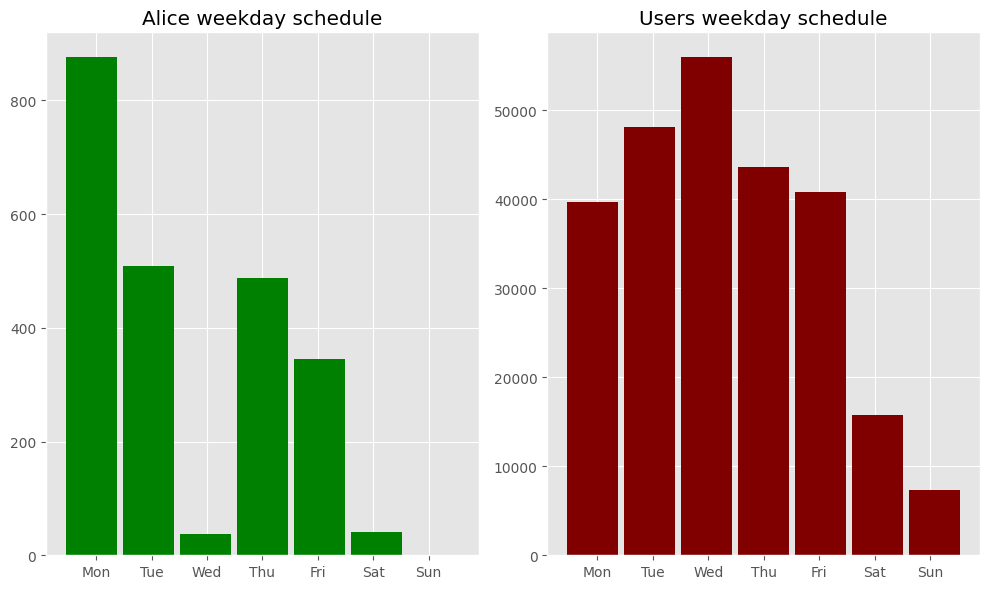

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(df_train[df_train.target==1].weekday, bins=7, color='green', label='Alice', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

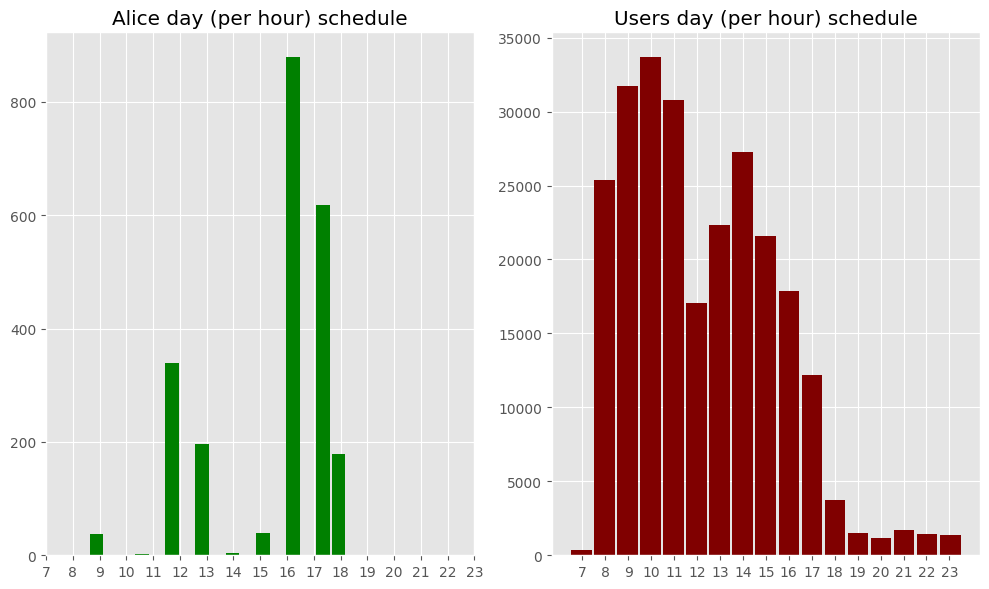

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(df_train[df_train.target==1].start_hour, bins=17, color='green', label='Alice', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].start_hour, bins=17, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].title.set_text('Alice day (per hour) schedule')
ax[1].title.set_text('Users day (per hour) schedule')
plt.tight_layout()
plt.show()

It looks like some periods, Alice rarely uses the Internet. Some hours Alice isn't using the Internet and sometimes even certain days she won't use it at all.

We should now transform data into a format that we can feed into CountVectorizer. This is a metod to convert text to numerical data by transforming text into a sparse matrix. If we have 8 words, we would have 8 different columns representing each unique word in the matrix.

In [25]:
sites = ['site%s' % i for i in range(1, 11)]
df_train[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
df_test[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)


Now let's fit our CountVectorizer to transform our data.

In [26]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

((253561, 50000), (82797, 50000))

In [27]:
y_train = df_train['target'].astype('int').values

In [28]:
time_split = TimeSeriesSplit(n_splits=10)

Let's run logistic regression now on the data and check with cross-validation how the model performed.

In [30]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1)

In [31]:
cv_scores, cv_scores.mean()

(array([0.88879256, 0.9141822 , 0.94706104, 0.9475289 , 0.94524675,
        0.96532786, 0.96160297, 0.94276388, 0.95707501, 0.95982078]),
 0.942940195552673)

Now let's train logistic regression on all of our training data and make our predictions for our test set accordingly.

In [32]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

Now we can create our first submission.

In [41]:
# logit_test_pred = logit.predict_proba(X_test)[:, 1]
# write_to_submission_file(logit_test_pred, 's1.csv')

Let's try to make small improvements by tuning our regularization parameter. We will fit 10 folds onto 10 candidates for 100 fits and use the best score in this grid search.

In [44]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [ ]:
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [ ]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred3, 's2.csv')